In [ ]:
# pip install datasets
from datasets import load_dataset

In [2]:
import warnings
from urllib3.exceptions import NotOpenSSLWarning

warnings.filterwarnings("ignore", category=NotOpenSSLWarning)
warnings.filterwarnings("ignore")

In [3]:
dataset_abstractive = load_dataset("sobamchan/aclsum", "abstractive", split="test")
dataset_extractive = load_dataset("sobamchan/aclsum", "extractive", split="test")

## Grid Search to look for the best K (max number of sentences)
Initially, we computed each heuristic using the **ROUGE-1** score metric from **Hugging Face**. However, since determining the best value of 
𝐾 (the maximum number of sentences) requires running all four heuristics across all documents for each value of K in the range [1, 32], this resulted in extremely expensive complexity.

To make the process tractable, I used an **incremental ROUGE-1 approximation**:

-   Instead of recomputing overlaps from scratch, I maintain a bag-of-words (BoW) count of all words already selected.

-   When considering a new sentence, I simply update the BoW and compute precision, recall, and F1 incrementally.

-   This greatly speeds up the computation because it avoids repeated concatenation and full ROUGE evaluation.

N.B. Local Score heuristic doesn't need the incremental approach, we could apply Hugging Face's R1 score directly. But we decided to keep the incremental approach in order to make it consistent with the results of other heuristics. 

Follows the tokenizer inspired by Hugging Face's tokenizer to compute Rouge-1 and the function which helps in approximating the Rouge-1 score incrementally.

In [4]:
import re
from collections import Counter

def hf_rouge_tokenize(text):
    """
    Hugging Face-inspired ROUGE-1 tokenizer.
    It lowercases text, splits on words and punctuation.
    """
    text = text.lower().strip()
    tokens = re.findall(r"\w+|[^\w\s]", text, re.UNICODE)
    return tokens

def rouge1_f1_incremental(selected_counts, candidate_counts, reference_counts):
    """
    Incrementally computes ROUGE-1 F1 for candidate summary.
    """
    merged_counts = selected_counts + candidate_counts
    overlap = sum((merged_counts & reference_counts).values())
    candidate_total = sum(merged_counts.values())
    reference_total = sum(reference_counts.values())
    
    if candidate_total == 0 or reference_total == 0:
        return 0.0
    
    precision = overlap / candidate_total
    recall = overlap / reference_total
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

The original Rouge-1 F1 from Hugging Face which will be used later.

In [5]:
from evaluate import load

rouge = load("rouge")

# Possibilities for rouge parameter are:  "rouge1", "rouge2", "rougeL"
def rouge_score(candidate, reference, rougex):
    result = rouge.compute(
        predictions=[candidate],
        references=[reference],
        rouge_types=[rougex]
    )
    r1 = result[rougex]
    return r1

### Heuristics with Rouge-1 incremental 
#### **Greedy Search**


In [73]:
def greedy_extractive_summary(sentences, abstractive_summary, max_sent=6):
    """
    Selects up to `max_sent` sentences using a greedy strategy with incremental ROUGE-1 F1.

    At each step, the sentence that maximizes the gain in ROUGE-1 F1 with respect
    to the reference summary is added to the selection.

    Args:
        sentences (list of str): Candidate sentences.
        abstractive_summary (str): Reference summary.
        max_sent (int): Maximum number of sentences to select (default=6).

    Returns:
        list of str: Selected sentences in chosen order.
    """
    sentences = [str(s) for s in sentences]
    reference_tokens = hf_rouge_tokenize(str(abstractive_summary))
    reference_counts = Counter(reference_tokens)
    sentence_counts = [Counter(hf_rouge_tokenize(s)) for s in sentences]
    
    selected = []
    selected_counts = Counter()
    remaining_idx = list(range(len(sentences)))
    
    while remaining_idx and max_sent > 0:
        best_idx = None
        best_score = -1.0
        
        for idx in remaining_idx:
            f1 = float(rouge1_f1_incremental(selected_counts, sentence_counts[idx], reference_counts))
            if f1 > best_score:
                best_score = f1
                best_idx = idx
        
        selected.append(sentences[best_idx])
        selected_counts += sentence_counts[best_idx]
        remaining_idx.remove(best_idx)
        max_sent -= 1
    
    return selected

#### **Beam Search**

In [74]:
def beam_extractive_summary(sentences, abstractive_summary, max_sent=6, beam_size=4):
    """
    Selects up to `max_sent` sentences using beam search with incremental ROUGE-1 F1.

    Maintains a beam of candidate sentence sets and expands them iteratively, keeping
    only the top `beam_size` candidates at each step.

    Args:
        sentences (list of str): Candidate sentences.
        abstractive_summary (str): Reference summary.
        max_sent (int): Maximum number of sentences to select (default=6).
        beam_size (int): Number of beams to keep during search (default=4).

    Returns:
        list of str: Selected sentences from the best beam.
    """
    sentences = [str(s) for s in sentences]
    reference_tokens = hf_rouge_tokenize(str(abstractive_summary))
    sentence_counts = [Counter(hf_rouge_tokenize(s)) for s in sentences]
    
    # Each beam: (selected_indices, merged_counts, current_score)
    beams = [([], Counter(), 0.0)]
    
    for _ in range(min(max_sent, len(sentences))):
        new_beams = []
        for selected_idx, merged_counts, _ in beams:
            remaining_idx = [i for i in range(len(sentences)) if i not in selected_idx]
            for idx in remaining_idx:
                f1 = float(rouge1_f1_incremental(
                    merged_counts, sentence_counts[idx], Counter(reference_tokens)
                ))
                new_beams.append((
                    selected_idx + [idx],
                    merged_counts + sentence_counts[idx],
                    f1
                ))
        if not new_beams:
            break
        new_beams.sort(key=lambda x: x[2], reverse=True)
        beams = new_beams[:beam_size]
    
    # Take the best beam
    best_selected, _, _ = beams[0]
    selected_sentences = [sentences[i] for i in best_selected]
    
    return selected_sentences

#### **Local Scorer**

In [ ]:
def local_extractive_summary(sentences, abstractive_summary, max_sent=3):
    """
    Local extractive summarization: rank sentences by ROUGE-1 F1 to reference.

    Args:
        sentences: list of sentences to select from
        abstractive_summary: reference summary
        max_sent: max number of sentences to select
    
    Returns:
        selected sentences (top max_sent) and final ROUGE-1 F1 score
    """
    sentences = [str(s) for s in sentences]
    abstractive_summary = str(abstractive_summary)
    
    reference_tokens = hf_rouge_tokenize(abstractive_summary)
    reference_counts = Counter(reference_tokens)
    
    sent_with_score = []
    for sent in sentences:
        candidate_counts = Counter(hf_rouge_tokenize(sent))
        f1 = float(rouge1_f1_incremental(Counter(), candidate_counts, reference_counts))
        sent_with_score.append({"sentence": sent, "r_score": f1})
    
    sent_with_score.sort(key=lambda x: x["r_score"], reverse=True)
    
    top_sentences = [s["sentence"] for s in sent_with_score[:max_sent]]
    
    return top_sentences

#### **Global Scorer**
As heuristic in order to find the best candidates we will use **Beam Search** heuristic.

In [ ]:
def global_extractive_summary(sentences, abstractive_summary, max_sent=3, beam_size=4):
    """
    Global extractive summarization: rank sentences by aggregated contribution across multiple beam search candidates.

    Args:
        sentences: list of sentences to select from
        abstractive_summary: reference summary
        max_sent: maximum number of sentences to return
        beam_size: number of beams to keep at each step

    Returns:
        selected_sentences: list of top max_sent sentences
        final_score: ROUGE-1 F1 of the final extractive summary vs reference
    """
    sentences = [str(s) for s in sentences]
    reference_tokens = hf_rouge_tokenize(str(abstractive_summary))
    reference_count = Counter(reference_tokens)
    sentence_counts = [Counter(hf_rouge_tokenize(s)) for s in sentences]

    # 1. Beam search to generate candidate extractive summaries
    beams = [([], Counter())]  # Each beam: (selected_indices, merged_counts)
    for _ in range(min(max_sent, len(sentences))):
        new_beams = []
        for selected_idx, merged_counts in beams:
            remaining_idx = [i for i in range(len(sentences)) if i not in selected_idx]
            for idx in remaining_idx:
                candidate_counts = merged_counts + sentence_counts[idx]
                # Use incremental F1 to sort beams locally
                score = rouge1_f1_incremental(merged_counts, sentence_counts[idx], reference_count)
                new_beams.append((selected_idx + [idx], candidate_counts, score))
        if not new_beams:
            break
        new_beams.sort(key=lambda x: x[2], reverse=True)
        beams = [(idxs, counts) for idxs, counts, _ in new_beams[:beam_size]]

    # 2. Compute full roug1 for each candidate summary
    candidates = []
    for selected_idx, _ in beams:
        candidate_sents = [sentences[i] for i in selected_idx]
        score = rouge1_f1_incremental(Counter(), merged_counts, reference_count)
        candidates.append((candidate_sents, score))


    # 3. Aggregate scores for each sentence across all candidates
    sentence_scores = {}
    for candidate_sents, score in candidates:
        for s in candidate_sents:
            sentence_scores[s] = sentence_scores.get(s, 0.0) + score

    # 4. Select top max_sent sentences
    sorted_sentences = sorted(sentence_scores.items(), key=lambda x: x[1], reverse=True)
    selected_sentences = [s for s, _ in sorted_sentences[:max_sent]]

    
    return selected_sentences

### Let's apply the heuristics
We first need a function which applies the heuristics over the whole dataset. It also has to keep the time required to process all the documents in order to evaluate performances of each heuristic.  

This function applies a given extractive summarization heuristic to all documents in parallel, **distributing the work across multiple CPU cores** to speed up processing.

In [6]:
import time
from joblib import Parallel, delayed

def apply_heuristic_to_dataset_parallel(heuristic_fn, docs_sentences, abstractive_summaries,
                                        max_sent=6, beam_size=0, n_jobs=-1):
    """
    Parallel evaluation of extractive summarization heuristics.
    
    Parameters
    ----------
    heuristic_fn : function
        Summarization function (beam, greedy, local, global).
    docs_sentences : list of list[str]
        Each document split into sentences.
    abstractive_summaries : list[str]
        Reference summaries.
    max_sent : int
        Maximum sentences to pick.
    beam_size : int
        Beam width (only used for beam/global).
    n_jobs : int
        Number of CPU cores (-1 = all cores).
    
    Returns
    -------
    selected_list : list[list[str]]
        Summaries selected for each document.
    scores_list : list[float]
        Final score for each document.
    elapsed_time : float
        Time taken to process all documents.
    """
    start_time = time.perf_counter()
    

    def process_one(sentences, abs_summary):
        if "beam" in heuristic_fn.__name__ or "global" in heuristic_fn.__name__:
            return heuristic_fn(sentences, abs_summary, max_sent=max_sent, beam_size=beam_size)
        else:
            return heuristic_fn(sentences, abs_summary, max_sent=max_sent)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_one)(sents, abs_summary)
        for sents, abs_summary in zip(docs_sentences, abstractive_summaries)
    )
    
    selected_list = [sel for sel in results]

    elapsed_time = time.perf_counter() - start_time
    return selected_list, elapsed_time

Names of the heuristics we will use and all the summaries.

In [7]:
heuristics = ["greedy_search", "beam_search", "local_score", "global_score"]
summ_types = ["challenge", "approach", "outcome", "all_together"]
singular_summ_types = ["challenge", "approach", "outcome"]

For each value of max_sent we will store the results in a list of dictionaries, each dictionary will have the following structure: 

In [8]:
results = {
    "challenge": {
        "greedy_search": {
            "result": [],
            "time": None,
        },
        "beam_search": {
            "result": [],
            "time": None,
        },
        "local_score": {
            "result": [],
            "time": None,
        },
        "global_score":{
            "result": [],
            "time": None,
        },
    },
    "approach": {
        "greedy_search": {
            "result": [],
            "time": None,
        },
        "beam_search": {
            "result": [],
            "time": None,
        },
        "local_score": {
            "result": [],
            "time": None,
        },
        "global_score":{
            "result": [],
            "time": None,
        },
    },
    "outcome": {
        "greedy_search": {
            "result": [],
            "time": None,
        },
        "beam_search": {
            "result": [],
            "time": None,
        },
        "local_score": {
            "result": [],
            "time": None,
        },
        "global_score":{
            "result": [],
            "time": None,
        },
    },
    "all_together": {
        "greedy_search": {
            "result": [],
            "time": None,
        },
        "beam_search": {
            "result": [],
            "time": None,
        },
        "local_score": {
            "result": [],
            "time": None,
        },
        "global_score":{
            "result": [],
            "time": None,
        },
    }
}

We now need the list of the source sentences from the dataset (the input). The list of sentences predicted and the time taken will be stored.

In [9]:
list_source_sentences = list(dataset_extractive["source_sentences"])

In [10]:
beam_size = 4

Let's prepare all the abstractive summaries that willl be used in the heuristics.

In [11]:
list_all_summaries_abstractive = [
    [c, a, o] 
    for c, a, o in zip(
        dataset_abstractive["challenge"], 
        dataset_abstractive["approach"], 
        dataset_abstractive["outcome"]
    )
]

In [12]:
list_summaries = {
    'challenge': list(dataset_abstractive["challenge"]),
    'approach': list(dataset_abstractive["approach"]),
    'outcome': list(dataset_abstractive["outcome"]),
    'all_together': list_all_summaries_abstractive
}

We now have to iterate for every value of K in the interval [1, 32] and apply the 4 heuristics in order to get the results.

In [ ]:
import copy

all_results = []
for sum_sent in range(1,33):
    res = copy.deepcopy(results)
    for summary in summ_types:

        # Greedy Search
        res[summary]["greedy_search"]["result"], res[summary]["greedy_search"]["time"] = apply_heuristic_to_dataset_parallel(
            greedy_extractive_summary, list_source_sentences, list_summaries[summary], sum_sent)
        # Beam Search
        res[summary]["beam_search"]["result"], res[summary]["beam_search"]["time"] = apply_heuristic_to_dataset_parallel(
            beam_extractive_summary, list_source_sentences, list_summaries[summary], sum_sent, beam_size)
        # Local Score
        res[summary]["local_score"]["result"], res[summary]["local_score"]["time"] = apply_heuristic_to_dataset_parallel(
            local_extractive_summary, list_source_sentences, list_summaries[summary], sum_sent)
        # Global Score
        res[summary]["global_score"]["result"], res[summary]["global_score"]["time"]  = apply_heuristic_to_dataset_parallel(
            global_extractive_summary, list_source_sentences, list_summaries[summary], sum_sent, beam_size)
        
    all_results.append(res)

### Let's now find out which is the best value for K

We will treat differently the three singular summaries and their merged version. This has be done since they logically can have different better length. 

We first need to get all the gold labels for extractive summaries in order to get the scores for ROUGE F1 and then evaluate which value is the best for *max_sent*.

In [16]:
list_all_summaries_extractive = [
    " ".join([ 
        " ".join(c),   
        " ".join(a),  
        " ".join(o)  
    ])
    for c, a, o in zip(
        dataset_extractive["challenge_sentences"],
        dataset_extractive["approach_sentences"],
        dataset_extractive["outcome_sentences"]
    )
]

In [17]:
joined_gold_labels_extractive = {
    "challenge": [" ".join(sentences) for sentences in dataset_extractive["challenge_sentences"]],
    "approach": [" ".join(sentences) for sentences in dataset_extractive["approach_sentences"]],
    "outcome": [" ".join(sentences) for sentences in dataset_extractive["outcome_sentences"]],
    "all_together": list_all_summaries_extractive
}

We now need to get the correct Rouge-1 scores, moreover we will average over all the documents, getting the average Rouge-1 score for each heuristic and summary.

Since analysing these data might be a bit confusing, let's average over summaries dimension. In this way we will have an estimate of the best value across all kind of summaries. 

In [ ]:
avg_score_across_summaries = {i: {heur: 0 for heur in heuristics} for i in range(1, 33)}

for i in range(32):
    res = all_results[i]
    
    for heur in heuristics:
        sum_score = 0
        
        for summ in singular_summ_types:
            avg_score_doc = 0
            n_docs = len(res[summ][heur]["result"])

            for doc in range(n_docs):
                candidate = " ".join(res[summ][heur]["result"][doc])
                reference = " ".join(dataset_extractive[doc][summ+'_sentences'])
                avg_score_doc += rouge_score(candidate, reference, 'rouge1')
            
            sum_score += avg_score_doc / n_docs
    
        avg_score_across_summaries[i+1][heur] = round(sum_score / len(singular_summ_types), 2)

Let's do the same for the merged version of the three summaries.

In [88]:
avg_score_across_all_tog = {i: {heur: 0 for heur in heuristics} for i in range(1, 33)}

for i in range(32):
    res = all_results[i]
    
    for heur in heuristics:
        sum_score = 0
        avg_score_doc = 0
        n_docs = len(res["all_together"][heur]["result"])

        for doc in range(n_docs):
            candidate = " ".join(res["all_together"][heur]["result"][doc])
            reference = list_all_summaries_extractive[doc]
            avg_score_doc += rouge_score(candidate, reference, 'rouge1')
        sum_score += avg_score_doc / n_docs
    
        avg_score_across_all_tog[i+1][heur] = round(sum_score, 2)

At this point it's important to define a function in order to plot results and have a visual understanding of how well the 4 heuristics are performing over all the summaries. Moreover we will consider the average among the for heuristics and take the highest value to be considered as best value for the maximum number of sentences. 

In [18]:
import matplotlib.pyplot as plt

def plot_avg_score(result, title):
    max_sent_list = sorted(result.keys(), reverse=True)  
    heuristics = list(next(iter(result.values())).keys())

    plt.figure(figsize=(10, 6))

    # Plot individual heuristic lines
    for heur in heuristics:
        y_values = [result[max_sent][heur] for max_sent in max_sent_list]
        plt.plot(max_sent_list, y_values, label=heur)

    # Compute the average across heuristics
    avg_values = [
        sum(result[max_sent][heur] for heur in heuristics) / len(heuristics)
        for max_sent in max_sent_list
    ]
    plt.plot(max_sent_list, avg_values, marker='o', color='black', label='Average', linewidth=2)

    # Find the max point of the average line
    max_idx = avg_values.index(max(avg_values))
    max_x = max_sent_list[max_idx]
    max_y = avg_values[max_idx]

    # Annotate the max point
    plt.annotate(f'{max_x} sentences', 
             xy=(max_x, max_y), xytext=(max_x, max_y + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             ha='center')


    plt.xlabel("Max Sentences")
    plt.ylabel("Average Score")
    plt.title(title)
    plt.xticks(max_sent_list) 
    plt.legend()
    plt.grid(True, alpha=0.3)  # more transparent grid
    plt.tight_layout()
    plt.show()

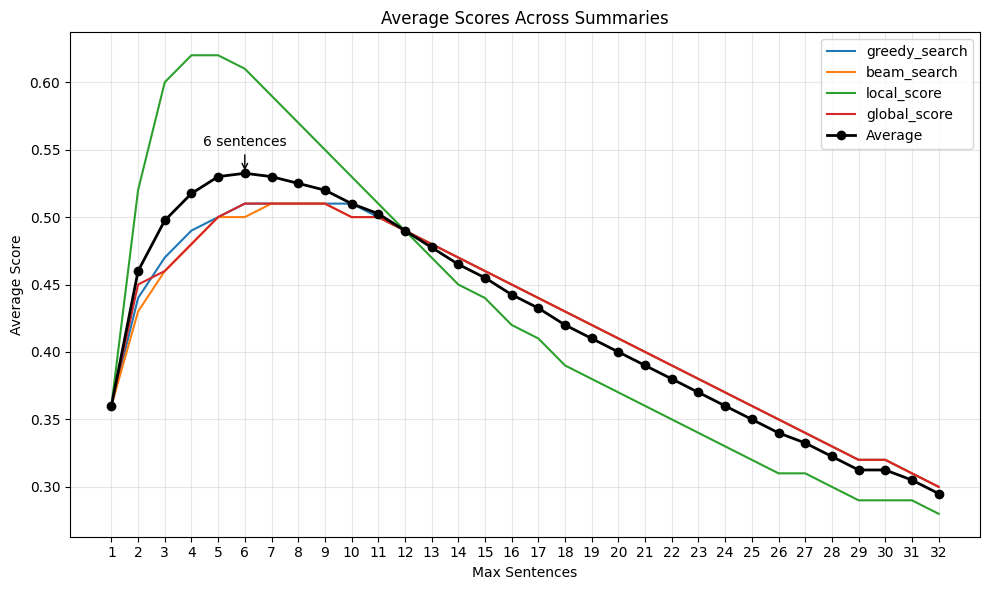

In [90]:
plot_avg_score(avg_score_across_summaries, "Average Scores Across Summaries")

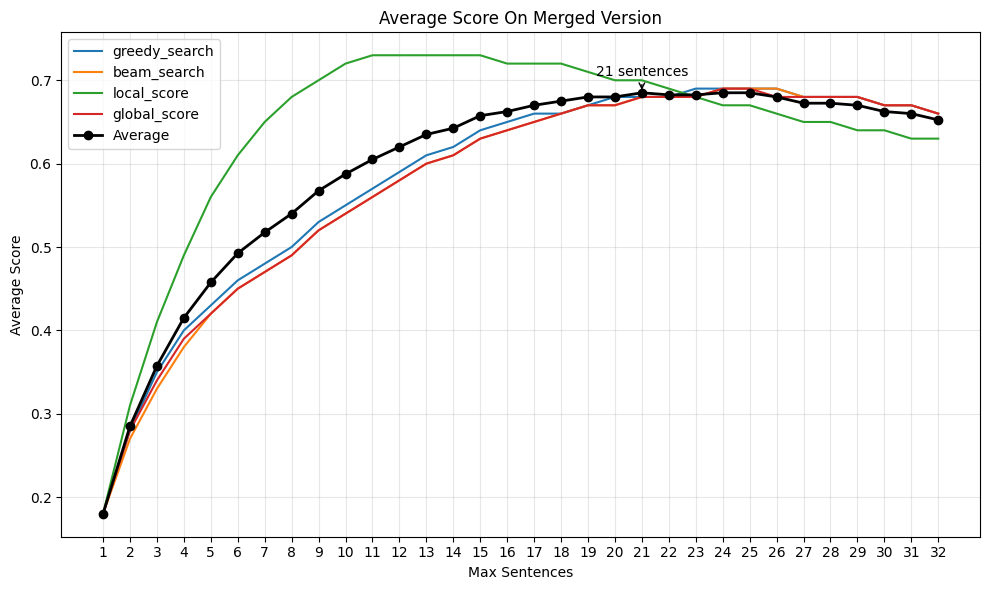

In [91]:
plot_avg_score(avg_score_across_all_tog, 'Average Score On Merged Version')

Just out of curiosity let's plot the performances and then the best value for the number of sentence individually for each kind of singular summary. 

In [117]:
avg_score_challenge = {i: {heur: 0 for heur in heuristics} for i in range(1, 33)}

for i in range(32):
    res = all_results[i]
    
    for heur in heuristics:
        sum_score = 0
        avg_score_doc = 0
        n_docs = len(res["challenge"][heur]["result"])

        for doc in range(n_docs):
            candidate = " ".join(res["challenge"][heur]["result"][doc])
            reference = " ".join(dataset_extractive[doc]["challenge_sentences"])
            avg_score_doc += rouge_score(candidate, reference, 'rouge1')
        
        sum_score += avg_score_doc / n_docs

        avg_score_challenge[i+1][heur] = round(sum_score, 2)

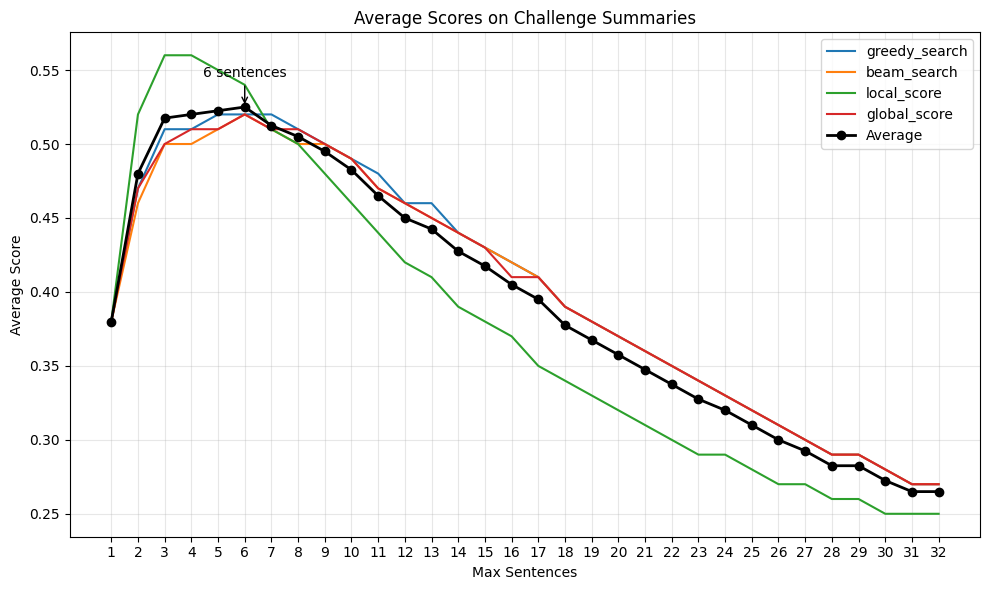

In [118]:
plot_avg_score(avg_score_challenge, "Average Scores on Challenge Summaries")

In [120]:
avg_score_outcome = {i: {heur: 0 for heur in heuristics} for i in range(1, 33)}

for i in range(32):
    res = all_results[i]
    
    for heur in heuristics:
        sum_score = 0
        avg_score_doc = 0
        n_docs = len(res["outcome"][heur]["result"])

        for doc in range(n_docs):
            candidate = " ".join(res["outcome"][heur]["result"][doc])
            reference = " ".join(dataset_extractive[doc]["outcome_sentences"])
            avg_score_doc += rouge_score(candidate, reference, 'rouge1')
        
        sum_score += avg_score_doc / n_docs

        avg_score_outcome[i+1][heur] = round(sum_score, 2)

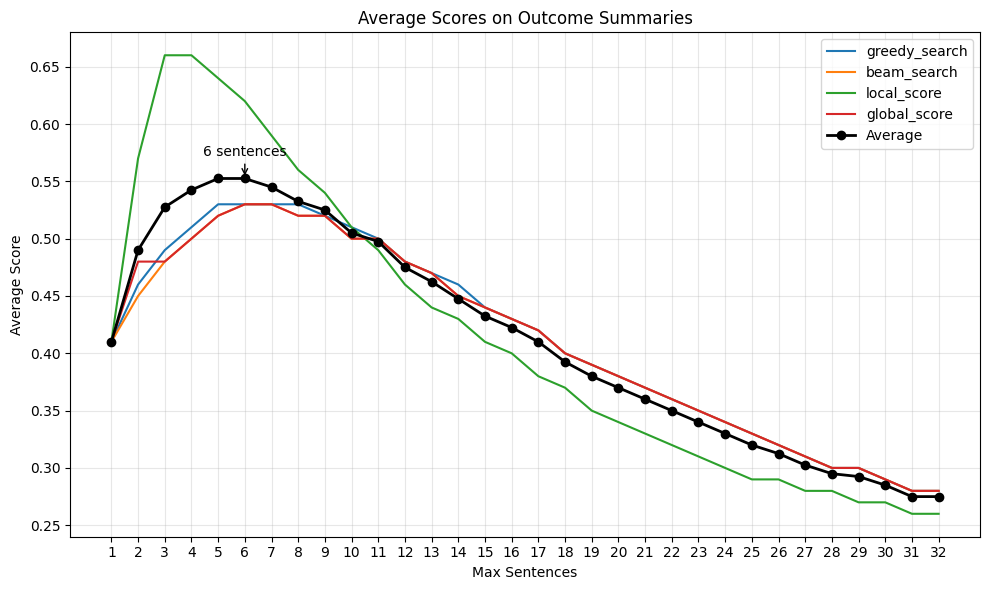

In [121]:
plot_avg_score(avg_score_outcome, "Average Scores on Outcome Summaries")

In [122]:
avg_score_approach = {i: {heur: 0 for heur in heuristics} for i in range(1, 33)}

for i in range(32):
    res = all_results[i]
    
    for heur in heuristics:
        sum_score = 0
        avg_score_doc = 0
        n_docs = len(res["approach"][heur]["result"])

        for doc in range(n_docs):
            candidate = " ".join(res["approach"][heur]["result"][doc])
            reference = " ".join(dataset_extractive[doc]["approach_sentences"])
            avg_score_doc += rouge_score(candidate, reference, 'rouge1')
        
        sum_score += avg_score_doc / n_docs

        avg_score_approach[i+1][heur] = round(sum_score, 2)

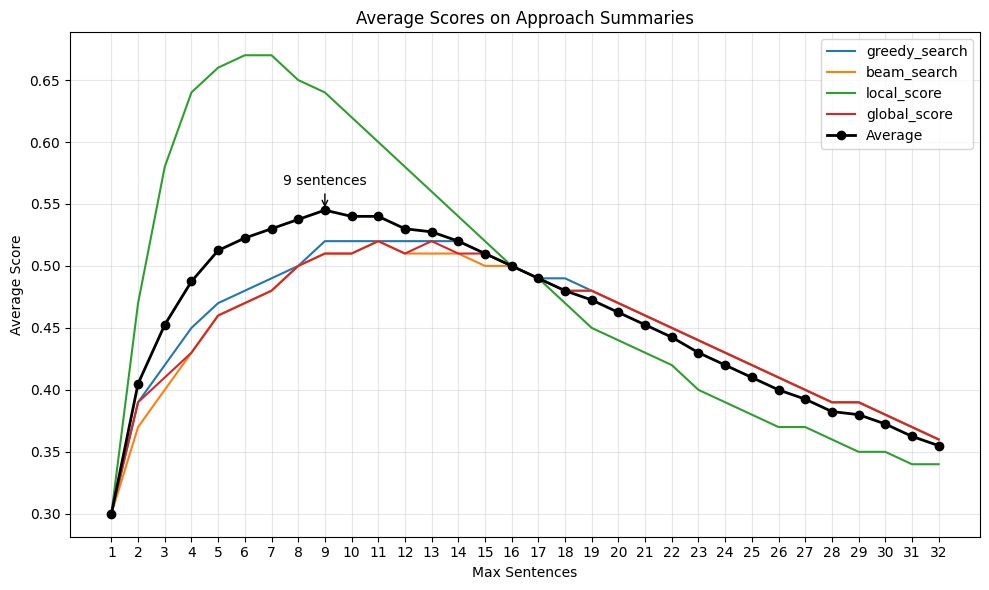

In [123]:
plot_avg_score(avg_score_approach, "Average Scores on Approach Summaries")

We have found out that the best values for the maximum number of sentences are:
-   **6** for **Challenge** and **Outcome**
-   **9** for **Approach**
-   **21** for their **merged version** (which makes sense since is the sum of 6 + 6 + 9 = 21).

In order to understand how close these heuristics are to the gold extractive label, let's print the average length of gold extractive summaries for each single summary.

In [125]:
gold_avg_approach = 0
gold_avg_challenge = 0
gold_avg_outcome = 0

for app, chal, out in zip(dataset_extractive["approach_sentences"], dataset_extractive["challenge_sentences"], dataset_extractive["outcome_sentences"]):
    gold_avg_approach += len(app)
    gold_avg_challenge += len(chal)
    gold_avg_outcome += len(out)

print("Average length of Approach Summaries is: ", gold_avg_approach/len(dataset_extractive["approach_sentences"]))
print("Average length of Challenge Summaries is: ", gold_avg_challenge/len(dataset_extractive["challenge_sentences"]))
print("Average length of Outcome Summaries is: ", gold_avg_outcome/len(dataset_extractive["outcome_sentences"]))

Average length of Approach Summaries is:  6.05
Average length of Challenge Summaries is:  4.14
Average length of Outcome Summaries is:  4.35


It seems that our heuristics need to pick more sentences in order to get a nice value of similarity with the label, specifically:
-   for **Approach** we need +3 sentences;
-   for **Challenge** and **Outcome** we need around +2 sentences;

From our results we can understand that:
-   the best average value across singular summaries  K is **6**;
-   the best value for K for their merged version is: **21**.

In [20]:
max_sent_singular = 6
max_sent_all = 21

### Heuristic Evaluation for the Best Value of K
We now want to understand how well each heuristic performs both in terms of time and the similarity with the gold extractive labels. 

In [ ]:
import pandas as pd
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_total_time(results, title='Total Time Taken by Each Heuristic'):
    """
    Plots a bar chart of the total time taken by each heuristic.

    Args:
        results (dict): The nested dictionary containing the time data.
    """
    heuristic_times = {
        "greedy_search": 0,
        "beam_search": 0,
        "local_score": 0,
        "global_score": 0,
    }

    for summary_type in results:
        for heuristic, data in results[summary_type].items():
            if data["time"] is not None:
                heuristic_times[heuristic] += data["time"]

    df = pd.DataFrame(
        list(heuristic_times.items()),
        columns=['Heuristic', 'Total Time (s)']
    )

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x='Heuristic',
        y='Total Time (s)',
        data=df,
        palette='viridis'
    )
    plt.title(title)
    plt.ylabel('Total Time (seconds)')
    plt.xlabel('Heuristic')
    plt.xticks(rotation=45, ha='right')

    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.2f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points'
        )

    plt.tight_layout()
    plt.show()

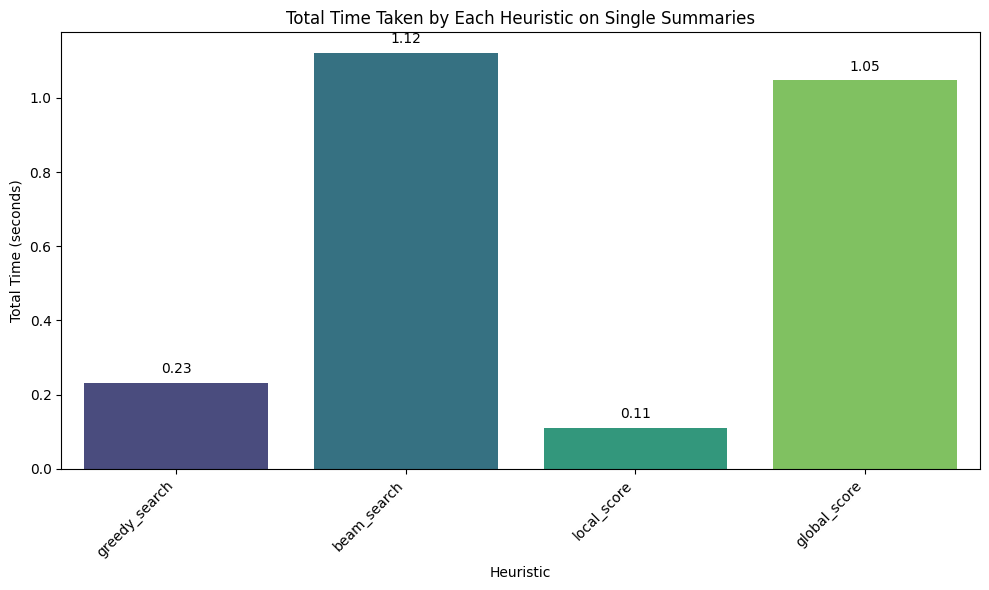

In [127]:
plot_total_time(all_results[max_sent_singular-1], 'Total Time Taken by Each Heuristic on Single Summaries')

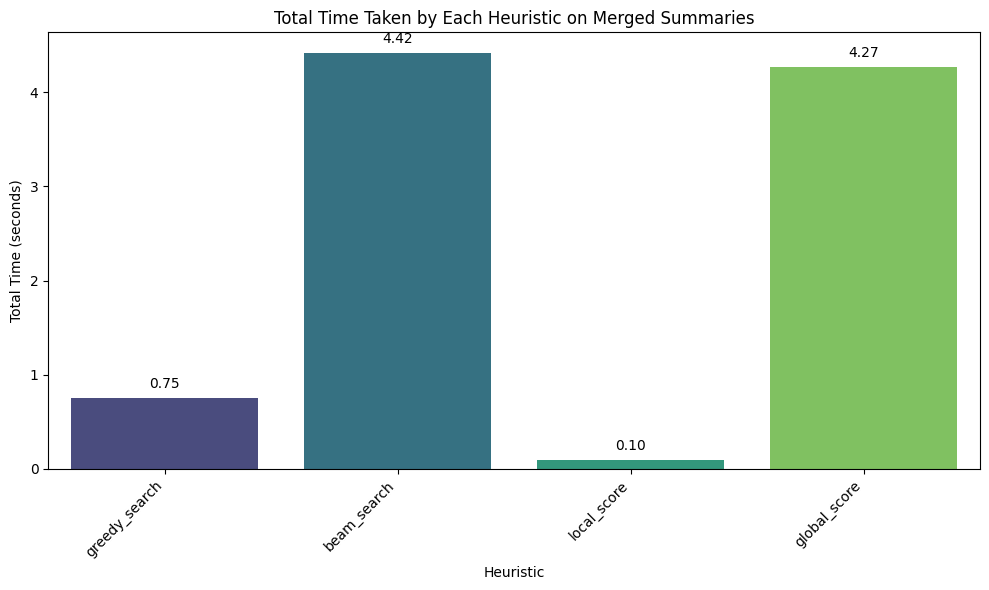

In [128]:
plot_total_time(all_results[max_sent_all-1], 'Total Time Taken by Each Heuristic on Merged Summaries')

It seems that **Beam search** is the heuristic which takes the most time, around 1.1 seconds on single summaries and 4.4 on their merged version, on average for each document. **Global score** heuristics behave similarly to Beam Search, even if slighlty better (global_extractive_summary is faster because it defers expensive full ROUGE computations until the end, while beam_extractive_summary recalculates scores for every beam expansion).

**Greedy search** and **Local Score** are much simpler approaches and require much less time compared to Beam Search and Global Score. **Local Score** is the fastest among all heuristics due to its semplicity. 

Processing all the summary together obviously require more time, almost x4 for all heuristics but **Local Score**, which has a light increase in time.

Let's now evaluate the similarity achieved in the results of each Heuristic.

In [ ]:
def plot_histogram_with_values(data, x_label="Heuristic", y_label="R1", title="Histogram"):
    """
    Plots a histogram with values on top of each bar.

    Args:
        data (dict): A dictionary where keys are the categories and values are the bar heights.
        x_label (str): The label for the x-axis.
        y_label (str): The label for the y-axis.
        title (str): The title of the plot.
    """
    df = pd.DataFrame(list(data.items()), columns=[x_label, y_label])

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=x_label, y=y_label, data=df, palette='viridis')
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xticks(rotation=45, ha='right')

    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.2f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points'
        )
    plt.tight_layout()
    plt.show()

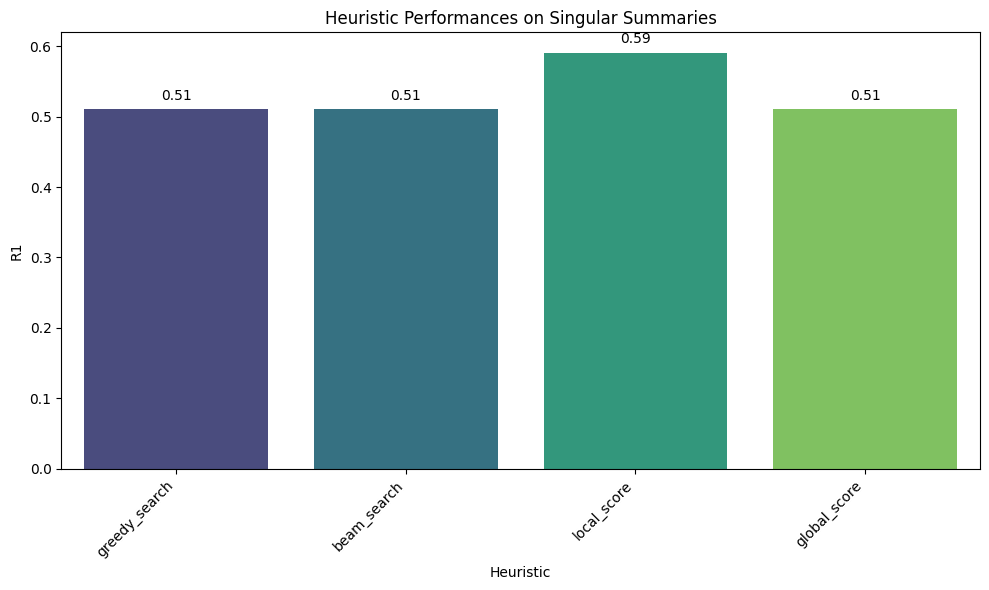

In [97]:
plot_histogram_with_values(avg_score_across_summaries[max_sent_singular], title="Heuristic Performances on Singular Summaries")

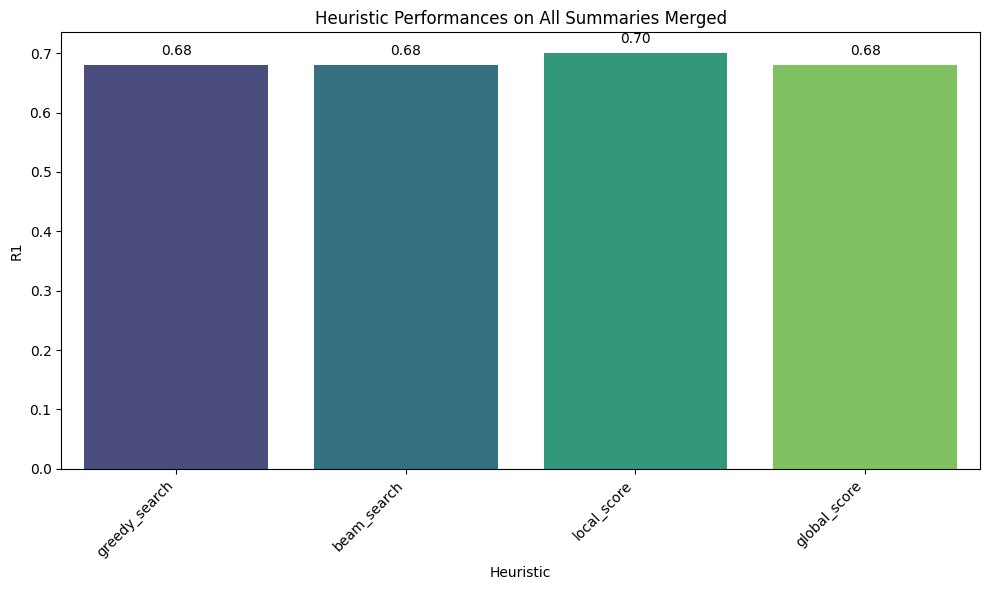

In [98]:
plot_histogram_with_values(avg_score_across_all_tog[max_sent_all], title="Heuristic Performances on All Summaries Merged")

As we can see from the average score graphs, Greedy Search, Beam Search, and Global Score achieve very similar results, even though they use different approaches. Local Score, despite being the most naive method, outperforms the other three heuristics. This difference diminishes as the number of sentences increases; in the merged version, the difference is minimal.

A possible interpretation of these results is that the local score heuristic likely performs better because its simple, the direct approach of picking the top-scoring individual sentences aligns more effectively with the ROUGE metric. In contrast, the greedy and beam search heuristics use a complex, cumulative scoring method that can lead to redundancy and discard valuable sentences. The global heuristic is particularly weak as it scores sentences indirectly based on how often they appear in other top summaries, which might not be an effective measure of their individual quality. 

Let's now check the similarity for each kind of summary.

In [ ]:
# Computing values for single summaries
avg_score_across_heuristics = {"challenge": 0, "approach": 0, "outcome": 0, "all_together": 0}
best_res = all_results[max_sent_singular-1]

for summ in singular_summ_types:
    avg_score = 0
    
    for heur in heuristics:
        avg_score_doc = 0
        n_docs = len(best_res[summ][heur]["result"])

        for doc in range(n_docs):
            candidate = " ".join(best_res[summ][heur]["result"][doc])
            reference = dataset_extractive[doc][summ+'_sentences']
            score = rouge_score(candidate, reference, 'rouge1')
            avg_score_doc += score
        avg_score += avg_score_doc / n_docs
    
    avg_score = avg_score / len(heuristics)
    
    avg_score_across_heuristics[summ] = round(avg_score, 3)

In [ ]:
# Computing values for all summaries together
best_res_all = all_results[max_sent_all-1]

avg_score = 0
for heur in heuristics:
    avg_score_doc = 0
    n_docs = len(best_res_all["all_together"][heur]["result"])

    for doc in range(n_docs):
        candidate = " ".join(best_res_all["all_together"][heur]["result"][doc])
        reference = list_all_summaries_extractive[doc]
        score = rouge_score(candidate, reference, 'rouge1')
        avg_score_doc += rouge_score(candidate, reference, 'rouge1')
    avg_score += avg_score_doc / n_docs
    
avg_score = avg_score / len(heuristics)
avg_score_across_heuristics["all_together"] = round(avg_score, 3)

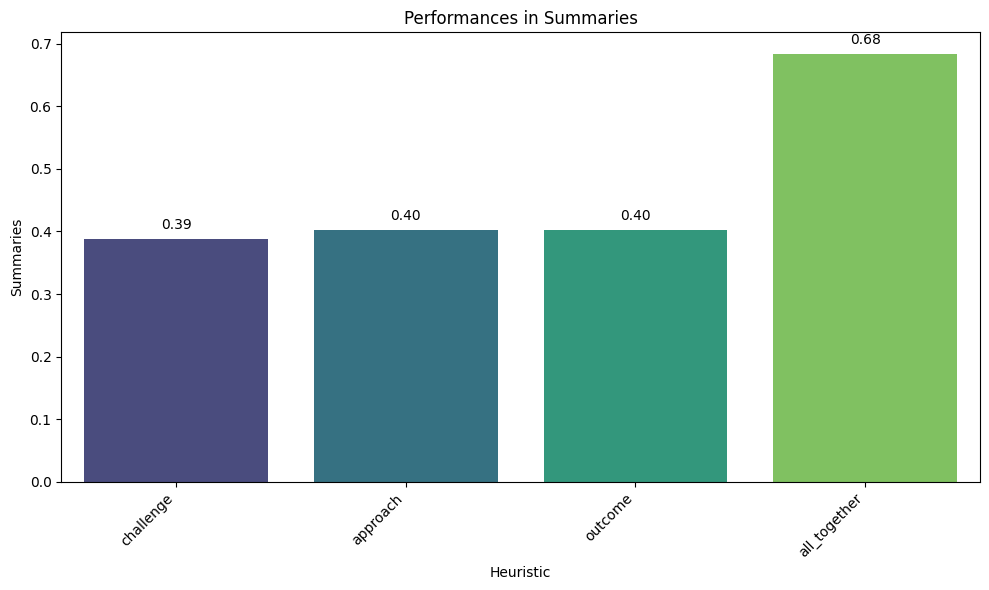

In [ ]:
plot_histogram_with_values(avg_score_across_heuristics, y_label="R1", title="Performances for different Summaries")

The results seem to be quite consistent for the singular summaries, but they are higher for their merged version. This is likely due to the nature of ROUGE-1, which does not normalize for length. This means that longer summaries are more likely to result in a higher ROUGE score.

This also explains why the best results for a the maximum number of sentences are higher compared to the average of the gold extractive labels. When optimizing for ROUGE-1, which favors longer summaries, the model naturally selects a larger number of sentences. At the same time not too high or it could include irrelevant words that make precision decrease and then result in a lower Rouge-1, this probably explains why results drops in similarity after a certain number of sentences.  

### Let's try with not approximative heuristics

As mentioned before, the incremental approach was used to simplify computation and is applied in all four heuristics. However, it does not use the proper Hugging Face ROUGE scorer.

The values we found for K are a good starting point, but to be certain and find the best value, we should define the four heuristics in their full version, using Hugging Face ROUGE-1.

It is also possible to run the same code using ROUGE-2 and ROUGE-L.

The 4 heuristics which try to optimize the Rouge-1 from Hugging Face.

In [ ]:
def greedy_extractive_summary_hf(sentences, abstractive_summaries, eval_criteria, max_sent):
    """
    Greedy extractive summarization.

    Iteratively selects up to `max_sent` sentences. At each step, picks the
    sentence that maximizes the ROUGE score (given by `eval_criteria`)
    against the reference summary.
    
    Args:
        sentences (list[str]): Candidate sentences.
        abstractive_summaries (str): Reference summary.
        eval_criteria (str): ROUGE metric to optimize ("rouge1", "rouge2", "rougeL").
        max_sent (int): Max number of sentences to select.

    Returns:
        list[str]: Selected sentences in order.
    """
    selected = []
    remaining = sentences[:]
    #mask = [0] * len(sentences)

    while remaining and max_sent != 0: 
        best_sentence = None
        best_score = -1
        for sent in remaining:
            
            candidate_summary = " ".join(selected + [sent])
            r1 = rouge_score(candidate_summary, abstractive_summaries, eval_criteria)
            if r1 > best_score:
                best_score = r1
                best_sentence = sent
       
        selected.append(best_sentence)
        idx = sentences.index(best_sentence)
        #mask[idx] = 1
        remaining.remove(best_sentence)
        max_sent -= 1
    
    #return selected, mask
    return selected

In [ ]:
def beam_extractive_summary_hf(sentences, abstractive_summary, eval_criteria, max_sent, beam_size=4, with_score=False):
    """
    Beam search extractive summarization.

    Expands candidate summaries by adding sentences step by step, keeping
    only the top `beam_size` by ROUGE score at each iteration. Returns
    either the best summary or all beams with scores.

    Args:
        sentences (list[str]): Candidate sentences.
        abstractive_summary (str): Reference summary.
        eval_criteria (str): ROUGE metric to optimize.
        max_sent (int): Max number of sentences to select.
        beam_size (int): Beam width (default=4).
        with_score (bool): If True, return (summary, score) pairs.

    Returns:
        list[str] or list[tuple]: Best summary sentences, or beam list with scores.
    """
    # Tuple of two items:
    #   -   selected sentences array
    #   -   ROUGE score
    beams = [([], 0.0)]
    
    for _ in range(min(max_sent, len(sentences))):
        new_beams = []
        for selected, _ in beams:
            remaining = [s for s in sentences if s not in selected]
            
            for sent in remaining:
                candidate_summary = " ".join(selected + [sent])
                r1 = rouge_score(candidate_summary, abstractive_summary, eval_criteria)
                
                new_beams.append((selected + [sent], r1))
        if not new_beams:
            break
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:beam_size]
    if with_score:
        return beams 
    return beams[0][0]

In [ ]:
def local_extractive_summary_hf(sentences, abstractive_summaries, eval_criteria, max_sent):
    """
    Local extractive summarization.

    Ranks sentences individually by ROUGE score against the reference
    summary and selects the top `max_sent`.

    Args:
        sentences (list[str]): Candidate sentences.
        abstractive_summaries (str): Reference summary.
        eval_criteria (str): ROUGE metric to optimize.
        max_sent (int): Number of top sentences to select.

    Returns:
        list[str]: Top-ranked sentences.
    """
    def rank_sentences():
        sent_with_score = []
        for sent in sentences:
            r1 = rouge_score(sent, abstractive_summaries, eval_criteria)
            sent_with_score.append({"sentence": sent, "r_score": r1})
        sent_with_score.sort(key=lambda x: x["r_score"], reverse=True)
        return [sent["sentence"] for sent in sent_with_score]

    sorted_sentences = rank_sentences()
    return sorted_sentences[:max_sent]

In [ ]:
def global_extractive_summary_hf(sentences, abstractive_summary, eval_criteria, max_sent, beam_size=4):
    """
    Global extractive summarization.

    Uses beam search to generate multiple candidate summaries, then
    scores each unique sentence by its total presence across candidates.
    Returns the top `max_sent` sentences with highest cumulative scores.

    Args:
        sentences (list[str]): Candidate sentences.
        abstractive_summary (str): Reference summary.
        eval_criteria (str): ROUGE metric to optimize.
        max_sent (int): Number of sentences to select.
        beam_size (int): Beam width for candidate generation.

    Returns:
        list[str]: Selected sentences ranked by global importance.
    """
    candidates = beam_extractive_summary_hf(sentences, abstractive_summary, eval_criteria, max_sent, beam_size, True)
    unique_sent_in_candidates = list(set([sent for candidate in [sents for sents, _ in candidates] for sent in candidate]))
    unique_sent_with_scores = []
    
    for sent in unique_sent_in_candidates:
        final_score = 0
        for cand, score in candidates:
            if sent in cand:
                final_score += score
        unique_sent_with_scores.append((sent, final_score))
    
    sorted_unique_sent_with_scores = sorted(unique_sent_with_scores, key=lambda x: x[1], reverse=True)

    best_sentences = [sent for sent, _ in sorted_unique_sent_with_scores][:max_sent]

    return best_sentences

In [ ]:
def apply_heuristic_to_dataset_hf(heuristic_fn, docs_sentences, abstractive_summaries, eval_criteria, max_sent=6, beam_size=0):
    """
    Apply an extractive summarization heuristic to a dataset.

    Iterates over documents, applies the given heuristic function to each,
    and collects the selected sentences. Measures total elapsed time.

    Args:
        heuristic_fn (callable): Extractive summary function to apply.
        docs_sentences (list[list[str]]): List of documents, each a list of sentences.
        abstractive_summaries (list[str]): List of reference summaries.
        eval_criteria (str): ROUGE metric to optimize.
        max_sent (int): Maximum number of sentences to select per document.
        beam_size (int): Beam size if the heuristic uses beam search (default=0).

    Returns:
        tuple: (list of selected sentences per document, elapsed time in seconds)
    """
    selected_list = []
    start_time = time.perf_counter()
    for sentences, abs_summary in zip(docs_sentences, abstractive_summaries):
        if beam_size > 0:
            selected = heuristic_fn(sentences, abs_summary, eval_criteria, max_sent, beam_size)
        else:
            selected = heuristic_fn(sentences, abs_summary, eval_criteria, max_sent)
            
        selected_list.append(selected)

    elapsed_time = time.perf_counter() - start_time

    return selected_list, elapsed_time

Let's try to apply a small grid search in the neighborhood of the best result we achieved with approximative heuristics in order to get the actual best value for K.

In [29]:
range_single_summaries = [4, 5, 6, 7, 8]
range_all_tog_summ = [19, 20, 21, 22, 23]

In [ ]:
slow_results = []
for sum_sent in range_single_summaries: 
    res = copy.deepcopy(results) 
    for summary in singular_summ_types: 
        # Greedy Search 
        res[summary]["greedy_search"]["result"], res[summary]["greedy_search"]["time"] = apply_heuristic_to_dataset_hf( 
            greedy_extractive_summary_hf, list_source_sentences, list_summaries[summary], 'rouge1', max_sent=sum_sent ) 
        # Beam Search 
        res[summary]["beam_search"]["result"], res[summary]["beam_search"]["time"] = apply_heuristic_to_dataset_hf( 
            beam_extractive_summary_hf, list_source_sentences, list_summaries[summary], 'rouge1', max_sent=sum_sent, beam_size=beam_size ) 
        # Local Score 
        res[summary]["local_score"]["result"], res[summary]["local_score"]["time"] = apply_heuristic_to_dataset_hf( 
            local_extractive_summary_hf, list_source_sentences, list_summaries[summary], 'rouge1', max_sent=sum_sent ) 
        # Global Score 
        res[summary]["global_score"]["result"], res[summary]["global_score"]["time"] = apply_heuristic_to_dataset_hf( 
            global_extractive_summary_hf, list_source_sentences, list_summaries[summary], 'rouge1', max_sent=sum_sent, beam_size=beam_size ) 
    
    slow_results.append(res)

In [31]:
avg_score_across_summaries_slow = {i: {heur: 0 for heur in heuristics} for i in range_single_summaries}

for idx, val in enumerate(range_single_summaries):
    res = slow_results[idx]
    
    for heur in heuristics:
        sum_score = 0
        
        for summ in singular_summ_types:
            avg_score_doc = 0
            n_docs = len(res[summ][heur]["result"])

            for doc in range(n_docs):
                candidate = " ".join(res[summ][heur]["result"][doc])
                reference = " ".join(dataset_extractive[doc][summ+'_sentences'])
                avg_score_doc += rouge_score(candidate, reference, 'rouge1')
            
            sum_score += avg_score_doc / n_docs
    
        avg_score_across_summaries_slow[val][heur] = round(sum_score / len(singular_summ_types), 2)

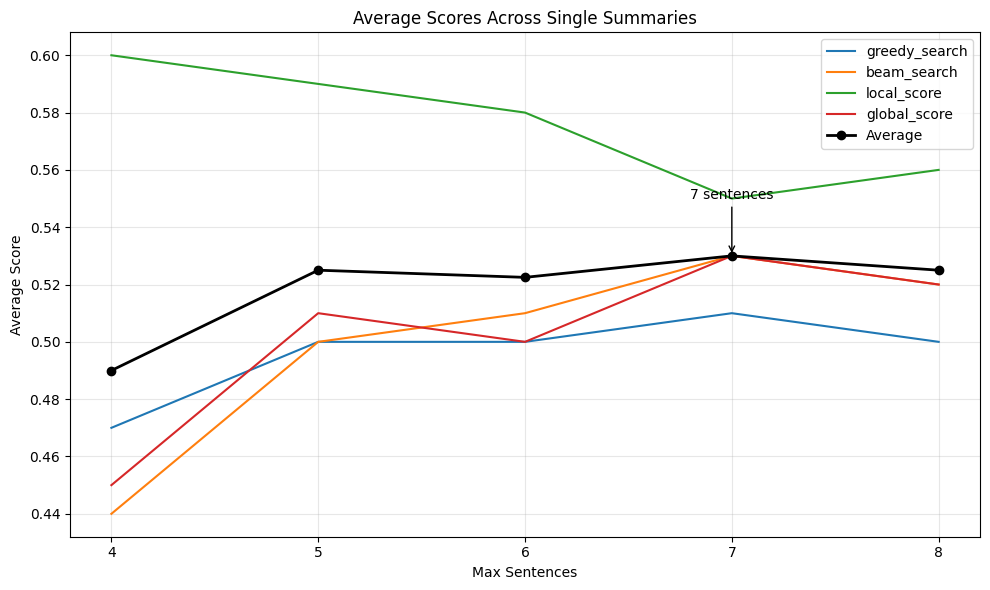

In [32]:
plot_avg_score(avg_score_across_summaries_slow, "Average Scores Across Single Summaries")

It seems that using the accurate heuristics the best value for the sentences is slightly moved towards **7**.

In [ ]:
template_all_tog = {
    "all_together": {
        "greedy_search": {'result': None, 'time': None},
        "beam_search": {'result': None, 'time': None},
        "local_score": {'result': None, 'time': None},
        "global_score": {'result': None, 'time': None}
    }
}
slow_results_all_tog = []

for sum_sent in range_all_tog_summ: 
    res = copy.deepcopy(template_all_tog)
     
    # Greedy Search 
    res['all_together']["greedy_search"]["result"], res['all_together']["greedy_search"]["time"] = apply_heuristic_to_dataset_hf( 
        greedy_extractive_summary_hf, list_source_sentences, list_summaries['all_together'], 'rouge1', max_sent=sum_sent ) 
    # Beam Search 
    res['all_together']["beam_search"]["result"], res['all_together']["beam_search"]["time"] = apply_heuristic_to_dataset_hf( 
        beam_extractive_summary_hf, list_source_sentences, list_summaries['all_together'], 'rouge1', max_sent=sum_sent, beam_size=beam_size ) 
    # Local Score 
    res['all_together']["local_score"]["result"], res['all_together']["local_score"]["time"] = apply_heuristic_to_dataset_hf( 
        local_extractive_summary_hf, list_source_sentences, list_summaries['all_together'], 'rouge1', max_sent=sum_sent ) 
    # Global Score 
    res['all_together']["global_score"]["result"], res['all_together']["global_score"]["time"] = apply_heuristic_to_dataset_hf( 
        global_extractive_summary_hf, list_source_sentences, list_summaries['all_together'], 'rouge1', max_sent=sum_sent, beam_size=beam_size ) 
    
    slow_results_all_tog.append(res)

In [34]:
avg_score_across_all_tog_slow = {i: {heur: 0 for heur in heuristics} for i in range_all_tog_summ}

for idx, val in enumerate(range_all_tog_summ):
    res = slow_results_all_tog[idx]
    
    for heur in heuristics:
        sum_score = 0
        avg_score_doc = 0
        n_docs = len(res["all_together"][heur]["result"])
        
        for doc in range(n_docs):
            candidate = " ".join(res["all_together"][heur]["result"][doc])
            reference = list_all_summaries_extractive[doc]
            score = rouge_score(candidate, reference, 'rouge1')
            avg_score_doc += score

        sum_score += avg_score_doc / n_docs
    
        avg_score_across_all_tog_slow[val][heur] = round(sum_score, 2)

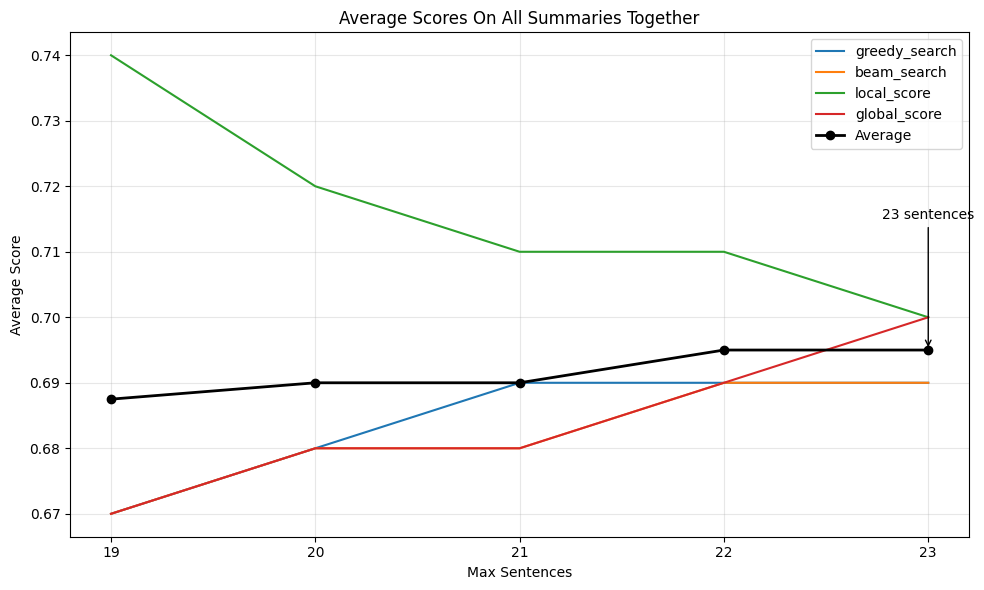

In [35]:
plot_avg_score(avg_score_across_all_tog_slow, "Average Scores On All Summaries Together")

As for singular summaries, also for the merged version the best values slighlty increased towards **23**.

Let's check the time taken to run these slow heuristics.

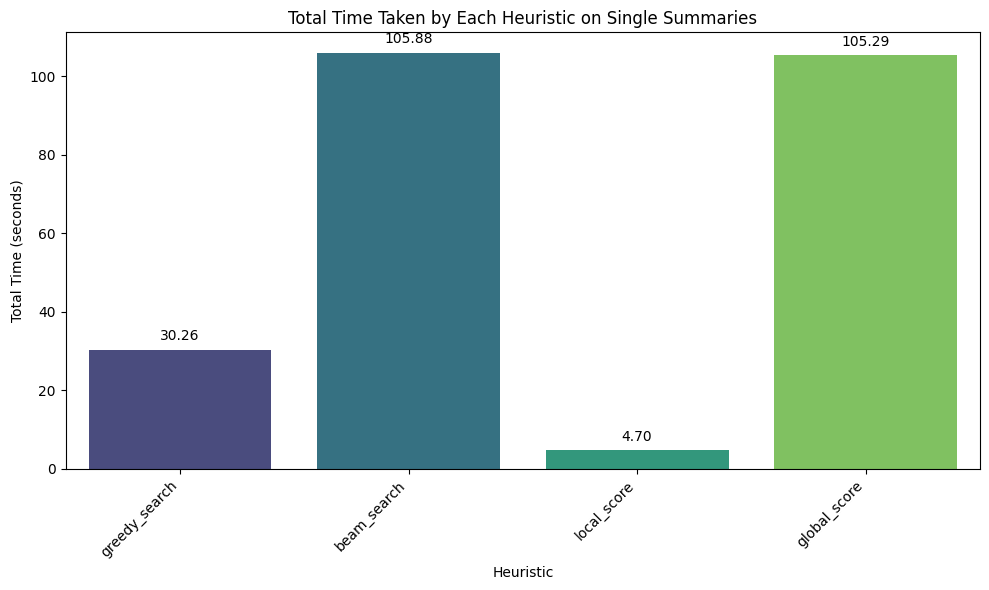

In [36]:
plot_total_time(slow_results[3], 'Total Time Taken by Each Heuristic on Single Summaries')

To notice the huge increase in time required on average for processing the documents. 

Let's quickly review the performances on the best value of K.

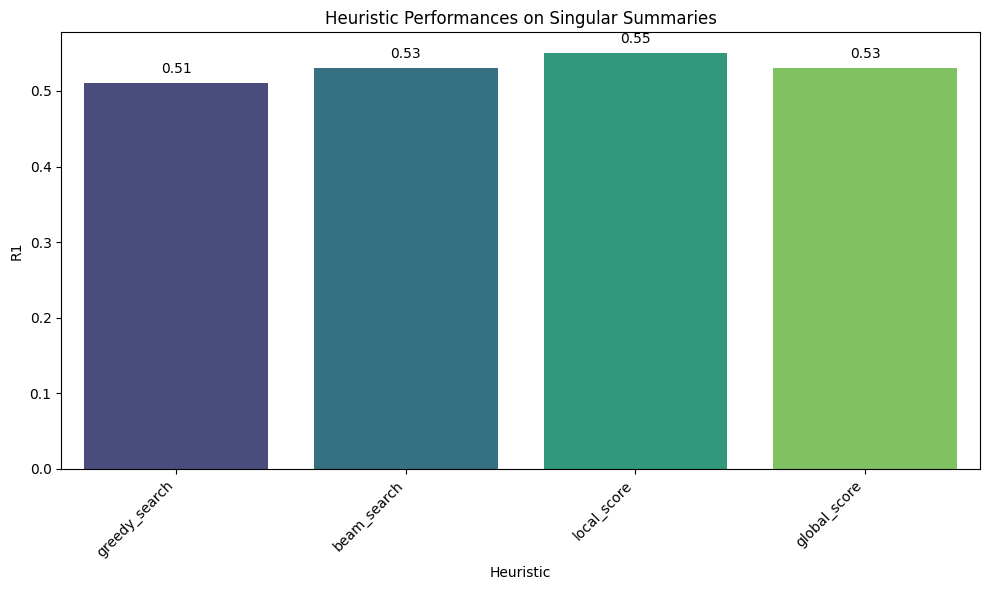

In [38]:
plot_histogram_with_values(avg_score_across_summaries_slow[7], title="Heuristic Performances on Singular Summaries")

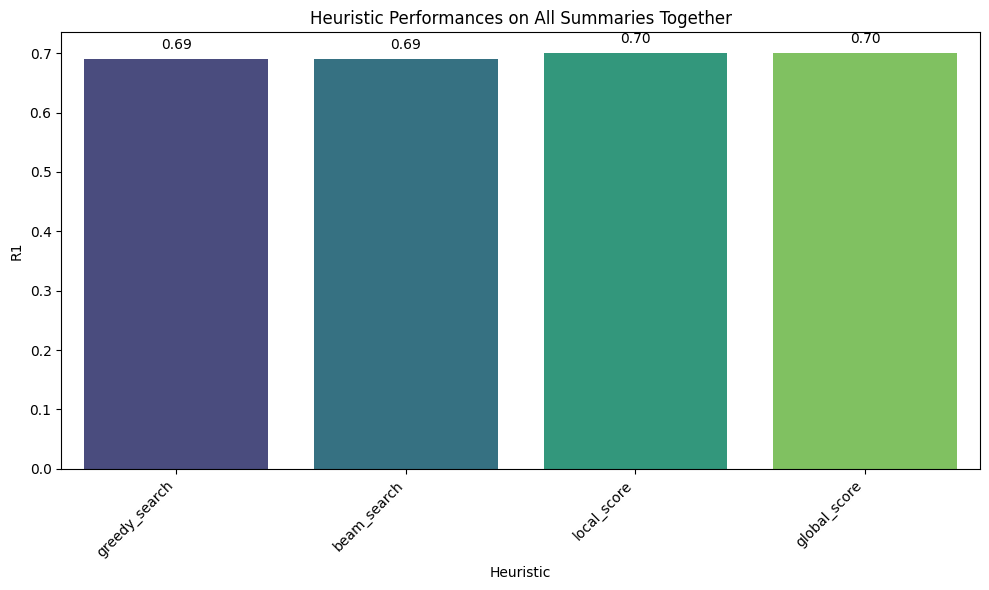

In [46]:
plot_histogram_with_values(avg_score_across_all_tog_slow[23], title="Heuristic Performances on All Summaries Together")

Results are quite similar to those we achieved with the approximative approach. There is a slight increment in Greedy Search, Beam Search and Global Score. On the contrary Local Score has slightly lower performances for singular summaries. It seems that the approximative approach worked quite well considering the much higher performances in terms of time.  

Among all the heuristics **Local Scor** with the **approximative approach** seems to be the better one in terms of time taken and lexical similarity.

---

### ROUGE-2 

Let's try running with Rouge-2 out of curiosity. It can be done the same with Rouge-L using 'rougel' when calling *apply_heuristic_to_dataset_hf* function.

In [ ]:
single_r2 = copy.deepcopy(results) 
for summary in singular_summ_types: 
    # Greedy Search 
    single_r2[summary]["greedy_search"]["result"], single_r2[summary]["greedy_search"]["time"] = apply_heuristic_to_dataset_hf( 
        greedy_extractive_summary_hf, list_source_sentences, list_summaries[summary], 'rouge2', max_sent=7 ) 
    # Beam Search 
    single_r2[summary]["beam_search"]["result"], single_r2[summary]["beam_search"]["time"] = apply_heuristic_to_dataset_hf( 
        beam_extractive_summary_hf, list_source_sentences, list_summaries[summary], 'rouge2', max_sent=7, beam_size=beam_size ) 
    # Local Score 
    single_r2[summary]["local_score"]["result"], single_r2[summary]["local_score"]["time"] = apply_heuristic_to_dataset_hf( 
        local_extractive_summary_hf, list_source_sentences, list_summaries[summary], 'rouge2', max_sent=7 ) 
    # Global Score 
    single_r2[summary]["global_score"]["result"], single_r2[summary]["global_score"]["time"] = apply_heuristic_to_dataset_hf( 
        global_extractive_summary_hf, list_source_sentences, list_summaries[summary], 'rouge2', max_sent=7, beam_size=beam_size ) 

In [56]:
avg_score_across_summaries_slow_r2 = {heur: 0 for heur in heuristics}

for heur in heuristics:
    sum_score = 0
    
    for summ in singular_summ_types:
        avg_score_doc = 0
        n_docs = len(single_r2[summ][heur]["result"])

        for doc in range(n_docs):
            candidate = " ".join(single_r2[summ][heur]["result"][doc])
            reference = " ".join(dataset_extractive[doc][summ+'_sentences'])
            avg_score_doc += rouge_score(candidate, reference, 'rouge2')
        
        sum_score += avg_score_doc / n_docs

    avg_score_across_summaries_slow_r2[heur] = round(sum_score / len(singular_summ_types), 2)

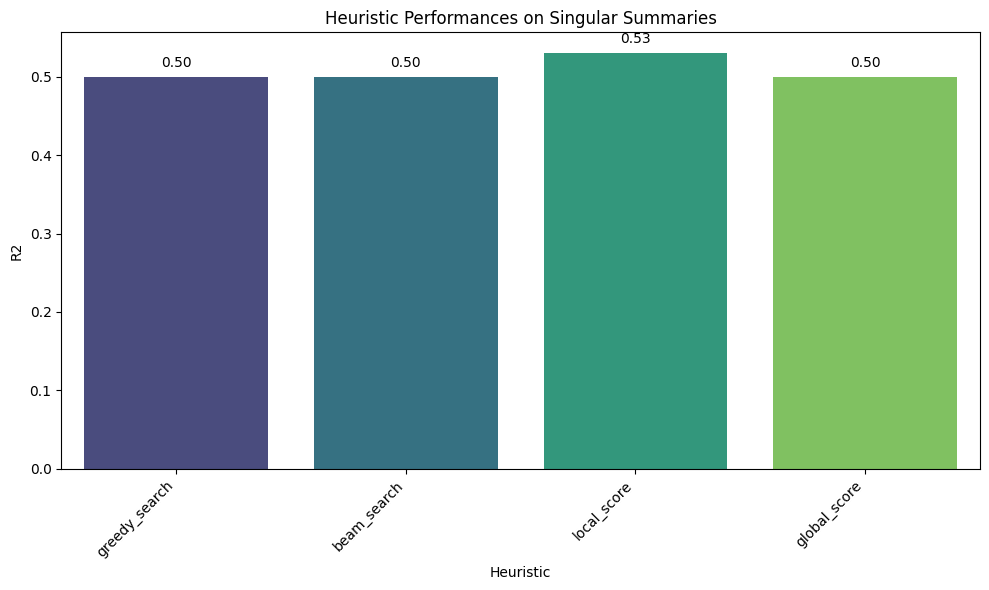

In [57]:
plot_histogram_with_values(avg_score_across_summaries_slow_r2, y_label="R2", title="Heuristic Performances on Singular Summaries")

In [ ]:
all_tog_r2 = copy.deepcopy(template_all_tog)
    
# Greedy Search 
all_tog_r2['all_together']["greedy_search"]["result"], all_tog_r2['all_together']["greedy_search"]["time"] = apply_heuristic_to_dataset_hf( 
    greedy_extractive_summary_hf, list_source_sentences, list_summaries['all_together'], 'rouge2', max_sent=sum_sent ) 
# Beam Search 
all_tog_r2['all_together']["beam_search"]["result"], all_tog_r2['all_together']["beam_search"]["time"] = apply_heuristic_to_dataset_hf( 
    beam_extractive_summary_hf, list_source_sentences, list_summaries['all_together'], 'rouge2', max_sent=sum_sent, beam_size=beam_size ) 
# Local Score 
all_tog_r2['all_together']["local_score"]["result"], all_tog_r2['all_together']["local_score"]["time"] = apply_heuristic_to_dataset_hf( 
    local_extractive_summary_hf, list_source_sentences, list_summaries['all_together'], 'rouge2', max_sent=sum_sent ) 
# Global Score 
all_tog_r2['all_together']["global_score"]["result"], all_tog_r2['all_together']["global_score"]["time"] = apply_heuristic_to_dataset_hf( 
    global_extractive_summary_hf, list_source_sentences, list_summaries['all_together'], 'rouge2', max_sent=sum_sent, beam_size=beam_size ) 

In [61]:
avg_score_across_all_tog_slow_r2 = {heur: 0 for heur in heuristics}

for heur in heuristics:
    sum_score = 0
    avg_score_doc = 0
    n_docs = len(all_tog_r2["all_together"][heur]["result"])
    
    for doc in range(n_docs):
        candidate = " ".join(all_tog_r2["all_together"][heur]["result"][doc])
        reference = list_all_summaries_extractive[doc]
        score = rouge_score(candidate, reference, 'rouge2')
        avg_score_doc += score

    sum_score += avg_score_doc / n_docs

    avg_score_across_all_tog_slow_r2[heur] = round(sum_score, 2)

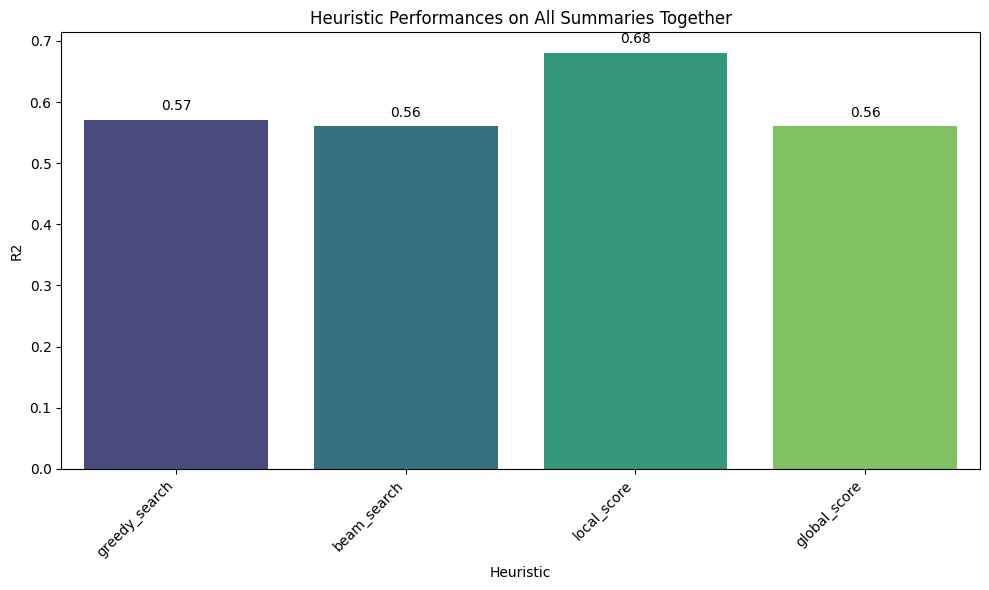

In [62]:
plot_histogram_with_values(avg_score_across_all_tog_slow_r2, y_label="R2", title="Heuristic Performances on All Summaries Together")

As expected results for Rouge-2 are lower since it's harder to match bigrams than unigrams as is done with Rouge-1. Let's try to compare the results of achieved optimising Rouge-2 using Rouge-1 as evaluation criteria, so that we can compare with results achieved by Rouge-1 optimisation.

In [63]:
avg_score_across_summaries_slow_r1 = {heur: 0 for heur in heuristics}

for heur in heuristics:
    sum_score = 0
    
    for summ in singular_summ_types:
        avg_score_doc = 0
        n_docs = len(single_r2[summ][heur]["result"])

        for doc in range(n_docs):
            candidate = " ".join(single_r2[summ][heur]["result"][doc])
            reference = " ".join(dataset_extractive[doc][summ+'_sentences'])
            avg_score_doc += rouge_score(candidate, reference, 'rouge1')
        
        sum_score += avg_score_doc / n_docs

    avg_score_across_summaries_slow_r1[heur] = round(sum_score / len(singular_summ_types), 2)

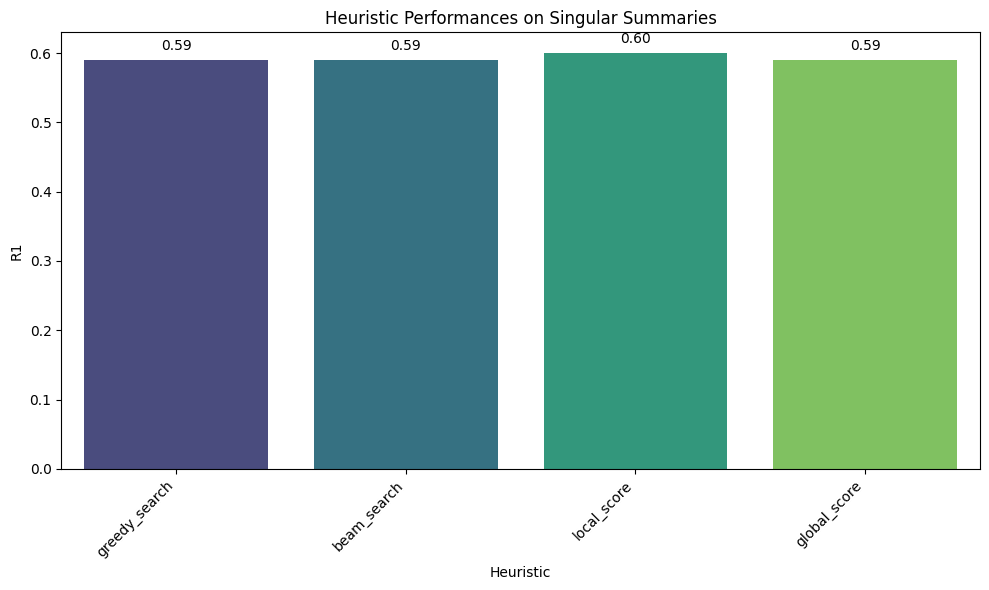

In [67]:
plot_histogram_with_values(avg_score_across_summaries_slow_r1, y_label="R1", title="Heuristic Performances on Singular Summaries")

In [65]:
avg_score_across_all_tog_slow_r1 = {heur: 0 for heur in heuristics}

for heur in heuristics:
    sum_score = 0
    avg_score_doc = 0
    n_docs = len(all_tog_r2["all_together"][heur]["result"])
    
    for doc in range(n_docs):
        candidate = " ".join(all_tog_r2["all_together"][heur]["result"][doc])
        reference = list_all_summaries_extractive[doc]
        score = rouge_score(candidate, reference, 'rouge1')
        avg_score_doc += score

    sum_score += avg_score_doc / n_docs

    avg_score_across_all_tog_slow_r1[heur] = round(sum_score, 2)

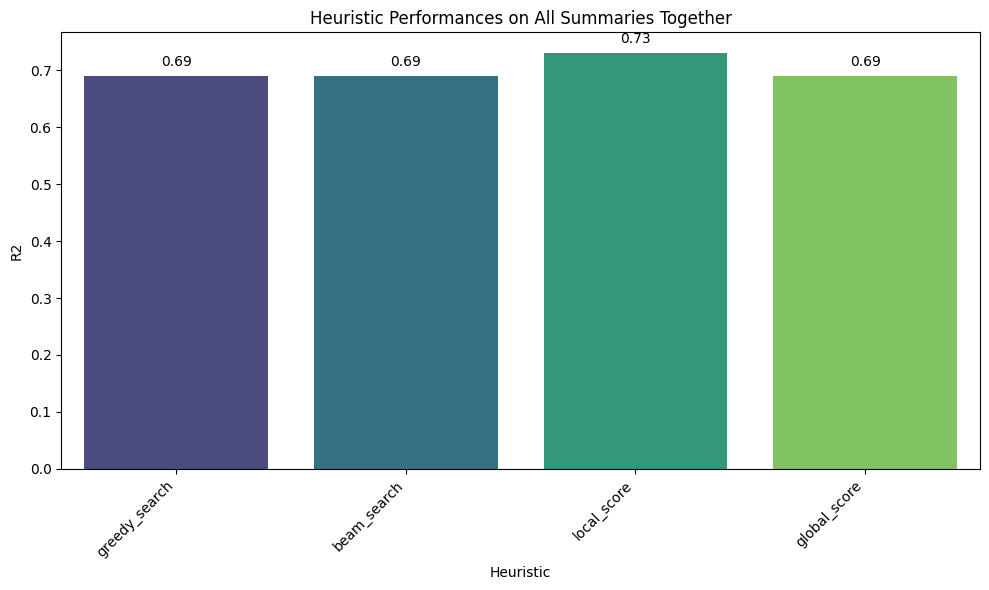

In [ ]:
plot_histogram_with_values(avg_score_across_all_tog_slow_r1, y_label="R1", title="Heuristic Performances on All Summaries Together")

There is a noticeable improvement in performance when optimizing with ROUGE-2 compared to ROUGE-1 on single summaries: the score increases from 0.51 to 0.59 for all heuristics, except for Local Score, which only increases by 0.01.

For the merged summaries, the results remain mostly stable, with a very slight improvement of 0.01 for all heuristics, except Local Score, which increases by 0.03.

This suggests that ROUGE-2 is a better similarity metric for optimizing our heuristics. However, the results are still not very high, likely because the optimization is based purely on lexical similarity. It would be interesting to try optimizing using different scoring metrics.